In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata



import os
import scipy
from scipy import sparse
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
import sys



%matplotlib inline 
import matplotlib.pyplot as plt
import datetime as datetime

import tensorflow as tf
import keras
import tensorboard
from keras.layers import Dense, Flatten, Reshape, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras import constraints
from keras.constraints import Constraint
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns 

sc.settings.verbosity = 3 
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()





/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,
Using TensorFlow backend.


scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


# open tensorboard and set log dir 

In [2]:
# log_dir = "./tmp/logs/"
# summary_writer = tf.summary.create_file_writer(logdir=log_dir)
# %load_ext tensorboard
# %tensorboard --logdir ./tmp/logs/

# Reading in already preprocessed input data

In [3]:
scaler = MinMaxScaler(feature_range=(-1, 1))

exp_mat = pd.read_csv("Gan_input_3_mg.csv", sep='\t', index_col = 0)
exp_mat = exp_mat.T

input_matrix = np.genfromtxt('Gan_input_3_mg.csv', skip_header=1)

input_matrix = input_matrix.T
input_matrix.shape


input_matrix = np.delete(input_matrix, (0), axis=0)

scaler.fit(input_matrix)
input_matrix = scaler.transform(input_matrix)


validation = input_matrix[np.random.choice(input_matrix.shape[0], 500, replace=False)]


# i  = np.random.randint(0, input_matrix[0].shape, 500)
# validation = input_matrix[i]
# input_matrix = np.delete(input_matrix, i, 0)


In [4]:
input_matrix.shape

(4727, 2774)

In [5]:
cell = input_matrix[1].shape
out_dim = cell[0]


In [6]:
# Model input dimensions



z_dim = 100 # noise vector size

In [7]:

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
    
    # clip model weights to hypercube
    def __call__(self, weights):
        return keras.backend.clip(weights, -self.clip_value, self.clip_value)
    
    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}
    
const = ClipConstraint(0.01)

In [8]:
# Generator as a function. Returns the generator network model.

def build_generator(cell, z_dim) :
  init = keras.initializers.RandomNormal(stddev=0.02)

  # Defines the model
  model = Sequential()

  # Adds a dense layer of 64 neurons with input_dim equal to z_dim
  model.add(Dense(128, kernel_initializer=init, input_dim = z_dim))

  model.add(LeakyReLU(alpha=0.2))

  model.add(Dense(200))

  model.add(LeakyReLU(alpha=0.2))


  # Adds another fully connected layer - output layer 
  model.add(Dense(out_dim, activation = 'tanh'))

  model.add(Reshape(cell))

  return model

In [9]:
# Defining the Discrimator network

def build_critic(cell) :
  init = keras.initializers.RandomNormal(stddev=0.02)

  model = Sequential()

  model.add(Dense(200,  kernel_initializer=init, input_shape = cell, kernel_constraint=const))

  model.add(LeakyReLU(alpha=0.2))
    
  model.add(Dense(200, kernel_constraint=const))

  model.add(LeakyReLU(alpha=0.2))

  model.add(Dense(1, kernel_constraint=const))

  return model

In [10]:
# wasserstein loss function

def wasserstein( y_true, y_pred):
    return -keras.backend.mean(y_true * y_pred)



critic = build_critic(cell)
critic.compile(loss = wasserstein,
                    optimizer = keras.optimizers.RMSprop(learning_rate = 0.00005),
                    metrics = ['accuracy'])


generator = build_generator(cell, z_dim)

def build_gan(generator, critic) :
  critic.trainable = False
  model = Sequential()

  model.add(generator)
  model.add(critic)

  return model


gan = build_gan(generator, critic)
gan.compile(loss= wasserstein, optimizer= keras.optimizers.RMSprop(learning_rate =  0.00005))

In [11]:
def generate_cells(number_cells) :
    
    # Draws from random normal.
    noise = np.random.normal(0, 1, (1, z_dim))
    
    # predcts using enerator network.
    gen_cell = generator.predict(noise)
    
    # Transform back from MinMax scaling between -1 and 1 (necesscary for tanh activation function) 
   # gen_cell = scaler.inverse_transform(gen_cell)


   # Repeat of above procedure inside a loop. 
    for cell in range(num_cells -1 ):
    
            noise = np.random.normal(0, 1, (1, z_dim))
    
            gen_cells_tmp = generator.predict(noise)
    
           # gen_cells_tmp = scaler.inverse_transform(gen_cells_tmp)
        
          #  Appends subsequent generated cells to form an array of generated cells
            gen_cell = np.append(gen_cell, gen_cells_tmp, axis=0)
    
    # Converts array to matrice object
    gen_cell = np.asmatrix(gen_cell)
    
    # converts matrice to pandas dataframe
    gen_cell = pd.DataFrame(gen_cell)
    
    # Loop to create cell names (theres deinitely a better way to do this)
    cell_names = []
    for i in range(num_cells ):
        cell_names.append("cell-{}".format(i +1))
        
        
    # Creates final dataframe with gene names and cell IDs
    gen_cell = pd.DataFrame(data=gen_cell.values, columns=exp_mat.columns, index = cell_names)
    
    return gen_cell


In [12]:
losses = []
accuracies = []
iteration_checkpoints = []
Generated_cells = []



def train_critic(X_train, batch_size):

    X_train =  input_matrix

    valid = np.ones((batch_size, 1))
    fake = -np.ones((batch_size, 1))
    
    # Train on real data
    idx = np.random.randint(0, X_train.shape[0], size = batch_size)
    real_cell = X_train[idx]
    c_loss_real = critic.train_on_batch(real_cell, valid)
    
    # Train on generated data
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    fake_cell = generator.predict(noise)
    c_loss_fake = critic.train_on_batch(fake_cell, fake)
    
    return c_loss_real, c_loss_fake

      



      

In [13]:
def train_generator(batch_size) :
    valid = np.ones((batch_size, 1))
    
    noise = np.random.normal(0,1, (batch_size, z_dim))
    gen_cell = generator.predict(noise)
    g_loss = gan.train_on_batch(noise, valid)
    return g_loss
    
    

In [14]:

def plot_history(c1_hist, c2_hist, c3_hist, g_hist):
    plt.plot(c1_hist, label='Critic loss on real cells')
    plt.plot(c2_hist, label='Critic loss on fake cells')
    plt.plot(c3_hist, label='Average critic loss')
    plt.plot(g_hist, label='Generator loss')
    
    plt.legend(fontsize = 'small')
    plt.savefig('plot_line_plot_loss.png')
    plt.show()
    plt.close()

In [15]:
# running the model

c_real_hist = []
c_fake_hist = []
c_hist_average = []
g_loss_hist = []


# Setting hyper parameters
epochs = 2000200
batch_size = 32
sample_interval = 1000
generate_cells_every = 100000
num_cells = 5000
X_train = input_matrix

for epoch in range(epochs):
    for _ in range(2):
        c_loss_real_tmp,  c_loss_fake_tmp = list(), list()
        c_loss_real, c_loss_fake = train_critic(X_train, batch_size= batch_size)
        c_loss_real_tmp.append(c_loss_real[0])
        c_loss_fake_tmp.append(c_loss_fake[0])
    c_real = np.mean(c_loss_real_tmp)
    c_real_hist.append(c_real)
    c_fake = np.mean(c_loss_fake_tmp)
    c_fake_hist.append(c_fake)
    c_average = c_fake, c_real
    c_hist_average.append(np.mean(c_average))
    
    g_loss = train_generator(batch_size)
    g_loss_hist.append(g_loss)

    
    if (epoch + 1) % sample_interval == 0: 
        iteration_checkpoints.append(epoch + 1)
        print ("%d [C loss real : %f], [C loss fake : %f] [G loss: %f]" % (epoch+1, c_loss_real[0],  c_loss_fake[0], g_loss))
    
        

    if (epoch +1) % generate_cells_every == 0:
        gen_cell = generate_cells(5000)
        Generated_cells.append(gen_cell)

plot_history(c_real_hist , c_fake_hist, c_hist_average, g_loss_hist)

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [C loss real : -2.002000], [C loss fake : 2.290792] [G loss: -2.200075]
2000 [C loss real : -0.112463], [C loss fake : 0.099021] [G loss: -0.080329]
3000 [C loss real : -0.057944], [C loss fake : 0.040980] [G loss: -0.019118]
4000 [C loss real : -0.055889], [C loss fake : 0.066301] [G loss: -0.048210]
5000 [C loss real : -0.063034], [C loss fake : 0.063364] [G loss: -0.046085]
6000 [C loss real : -0.087461], [C loss fake : 0.070417] [G loss: -0.049765]
7000 [C loss real : -0.105765], [C loss fake : 0.071766] [G loss: -0.059777]
8000 [C loss real : -0.117060], [C loss fake : 0.076957] [G loss: -0.050406]
9000 [C loss real : -0.115794], [C loss fake : 0.069939] [G loss: -0.039853]
10000 [C loss real : -0.089262], [C loss fake : 0.068349] [G loss: -0.060364]
11000 [C loss real : -0.116000], [C loss fake : 0.097652] [G loss: -0.077091]
12000 [C loss real : -0.087735], [C loss fake : 0.074206] [G loss: -0.054000]
13000 [C loss real : 0.053216], [C loss fake : -0.053711] [G loss: 0.0727

107000 [C loss real : -0.000801], [C loss fake : -0.000700] [G loss: 0.001229]
108000 [C loss real : -0.005420], [C loss fake : 0.005980] [G loss: 0.000584]
109000 [C loss real : 0.001217], [C loss fake : -0.000133] [G loss: 0.002004]
110000 [C loss real : 0.001470], [C loss fake : 0.000030] [G loss: 0.000159]
111000 [C loss real : -0.003930], [C loss fake : 0.001175] [G loss: 0.001999]
112000 [C loss real : -0.004389], [C loss fake : 0.003314] [G loss: 0.001823]
113000 [C loss real : -0.001715], [C loss fake : 0.000257] [G loss: 0.003987]
114000 [C loss real : -0.001589], [C loss fake : 0.000480] [G loss: 0.001974]
115000 [C loss real : 0.003986], [C loss fake : -0.004106] [G loss: 0.004632]
116000 [C loss real : -0.005803], [C loss fake : -0.004284] [G loss: -0.002831]
117000 [C loss real : -0.003558], [C loss fake : -0.000518] [G loss: 0.001810]
118000 [C loss real : -0.003472], [C loss fake : -0.006417] [G loss: 0.009420]
119000 [C loss real : -0.001623], [C loss fake : -0.009343] 

212000 [C loss real : 0.005490], [C loss fake : -0.010893] [G loss: 0.013351]
213000 [C loss real : 0.011542], [C loss fake : -0.010655] [G loss: 0.013948]
214000 [C loss real : 0.000163], [C loss fake : -0.010136] [G loss: 0.009964]
215000 [C loss real : -0.000463], [C loss fake : -0.008907] [G loss: 0.013775]
216000 [C loss real : 0.000994], [C loss fake : -0.012247] [G loss: 0.017906]
217000 [C loss real : 0.003787], [C loss fake : -0.010390] [G loss: 0.015526]
218000 [C loss real : 0.016025], [C loss fake : -0.012803] [G loss: 0.015687]
219000 [C loss real : 0.010376], [C loss fake : -0.005116] [G loss: 0.004628]
220000 [C loss real : 0.002771], [C loss fake : -0.013659] [G loss: 0.006231]
221000 [C loss real : 0.000165], [C loss fake : -0.007386] [G loss: 0.012074]
222000 [C loss real : 0.003252], [C loss fake : -0.015822] [G loss: 0.003168]
223000 [C loss real : 0.002918], [C loss fake : -0.018667] [G loss: 0.039311]
224000 [C loss real : 0.004728], [C loss fake : -0.013381] [G l

317000 [C loss real : 0.005343], [C loss fake : -0.021462] [G loss: 0.027808]
318000 [C loss real : 0.013731], [C loss fake : -0.026995] [G loss: 0.031663]
319000 [C loss real : 0.014646], [C loss fake : -0.031627] [G loss: 0.041382]
320000 [C loss real : 0.012051], [C loss fake : -0.026070] [G loss: 0.044974]
321000 [C loss real : 0.014294], [C loss fake : -0.022080] [G loss: 0.020837]
322000 [C loss real : 0.020195], [C loss fake : -0.027758] [G loss: 0.045916]
323000 [C loss real : 0.020487], [C loss fake : -0.034762] [G loss: 0.042430]
324000 [C loss real : 0.021743], [C loss fake : -0.029114] [G loss: 0.040467]
325000 [C loss real : 0.016489], [C loss fake : -0.023693] [G loss: 0.038003]
326000 [C loss real : 0.018894], [C loss fake : -0.019409] [G loss: 0.021124]
327000 [C loss real : 0.016192], [C loss fake : -0.030368] [G loss: 0.029419]
328000 [C loss real : 0.018202], [C loss fake : -0.029248] [G loss: 0.028573]
329000 [C loss real : 0.010360], [C loss fake : -0.024875] [G lo

423000 [C loss real : 0.025436], [C loss fake : -0.019872] [G loss: 0.045997]
424000 [C loss real : 0.027448], [C loss fake : -0.045920] [G loss: 0.039198]
425000 [C loss real : 0.024336], [C loss fake : -0.041633] [G loss: 0.046587]
426000 [C loss real : 0.033146], [C loss fake : -0.044519] [G loss: 0.041714]
427000 [C loss real : 0.032052], [C loss fake : -0.042226] [G loss: 0.048474]
428000 [C loss real : 0.025210], [C loss fake : -0.046095] [G loss: 0.059202]
429000 [C loss real : 0.022732], [C loss fake : -0.032066] [G loss: 0.046583]
430000 [C loss real : 0.027615], [C loss fake : -0.042921] [G loss: 0.046644]
431000 [C loss real : 0.022653], [C loss fake : -0.036272] [G loss: 0.043585]
432000 [C loss real : 0.030317], [C loss fake : -0.051535] [G loss: 0.056619]
433000 [C loss real : 0.029274], [C loss fake : -0.029540] [G loss: 0.047897]
434000 [C loss real : 0.037432], [C loss fake : -0.041072] [G loss: 0.048559]
435000 [C loss real : 0.026830], [C loss fake : -0.043591] [G lo

529000 [C loss real : 0.035096], [C loss fake : -0.048961] [G loss: 0.048316]
530000 [C loss real : 0.032998], [C loss fake : -0.045163] [G loss: 0.054176]
531000 [C loss real : 0.034294], [C loss fake : -0.044166] [G loss: 0.054045]
532000 [C loss real : 0.031975], [C loss fake : -0.046434] [G loss: 0.061613]
533000 [C loss real : 0.034841], [C loss fake : -0.051877] [G loss: 0.059894]
534000 [C loss real : 0.043673], [C loss fake : -0.054970] [G loss: 0.060899]
535000 [C loss real : 0.034359], [C loss fake : -0.046752] [G loss: 0.058219]
536000 [C loss real : 0.034977], [C loss fake : -0.045584] [G loss: 0.058544]
537000 [C loss real : 0.067917], [C loss fake : -0.049713] [G loss: 0.056423]
538000 [C loss real : 0.035943], [C loss fake : -0.048168] [G loss: 0.051158]
539000 [C loss real : 0.022971], [C loss fake : -0.027406] [G loss: 0.063636]
540000 [C loss real : 0.034264], [C loss fake : -0.045548] [G loss: 0.055315]
541000 [C loss real : 0.031454], [C loss fake : -0.044560] [G lo

KeyboardInterrupt: 

In [ ]:
#output = Generated_cells[4]
#output.to_csv('gen_cells.csv', sep='\t', index=True)

In [ ]:
plot_history(c_real_hist , c_fake_hist, c_hist_average, g_loss_hist)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)


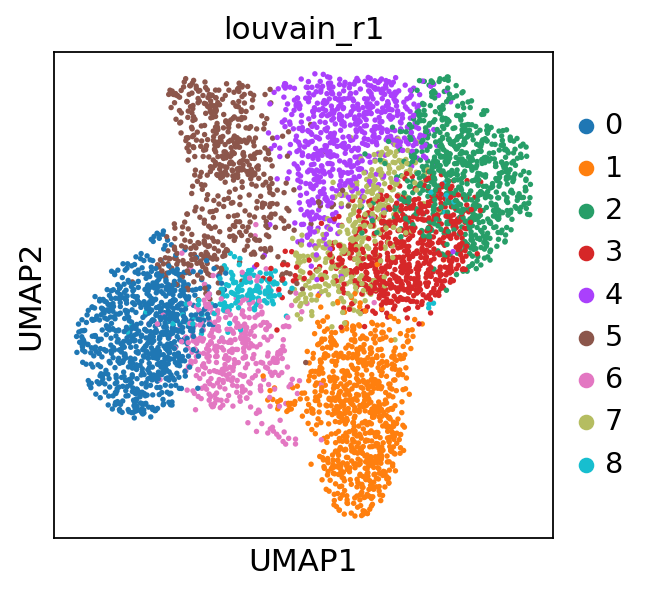

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:08)


/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


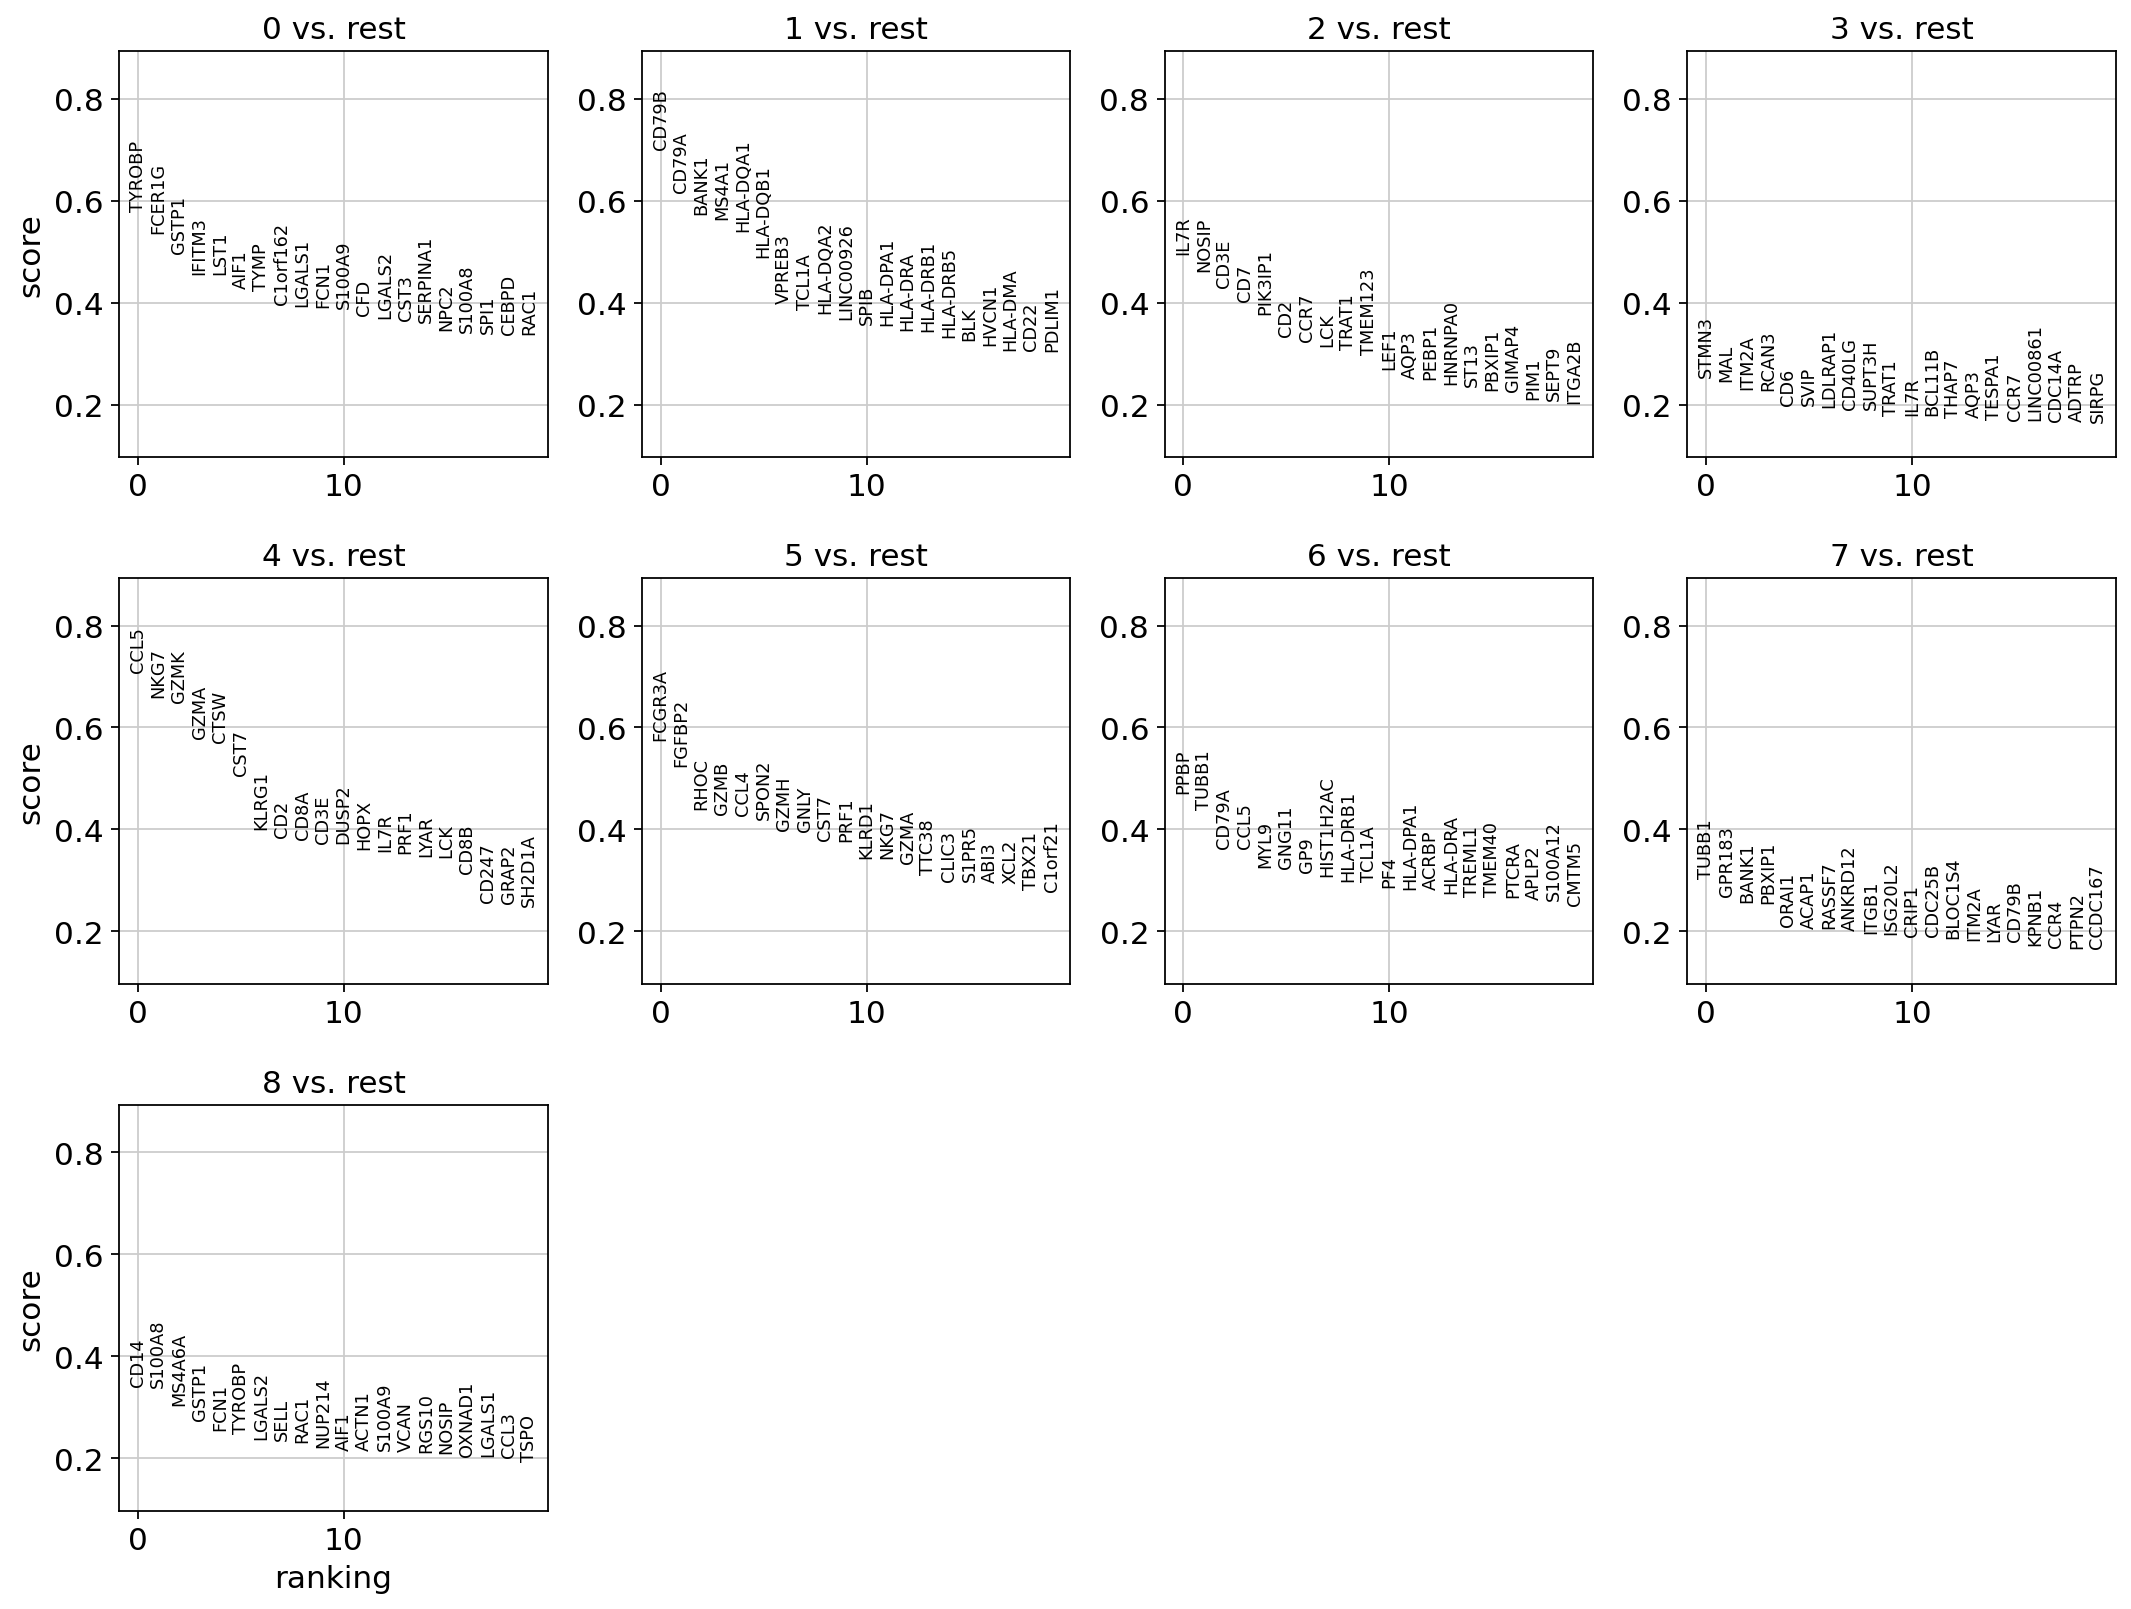

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)


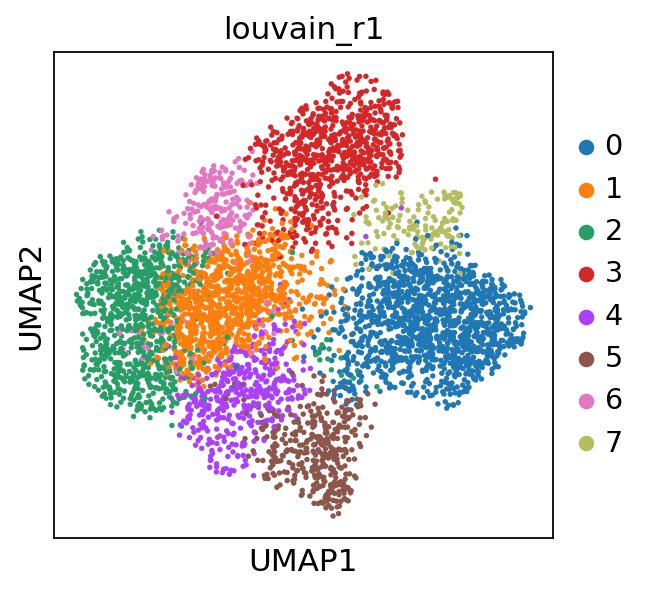

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:08)


/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


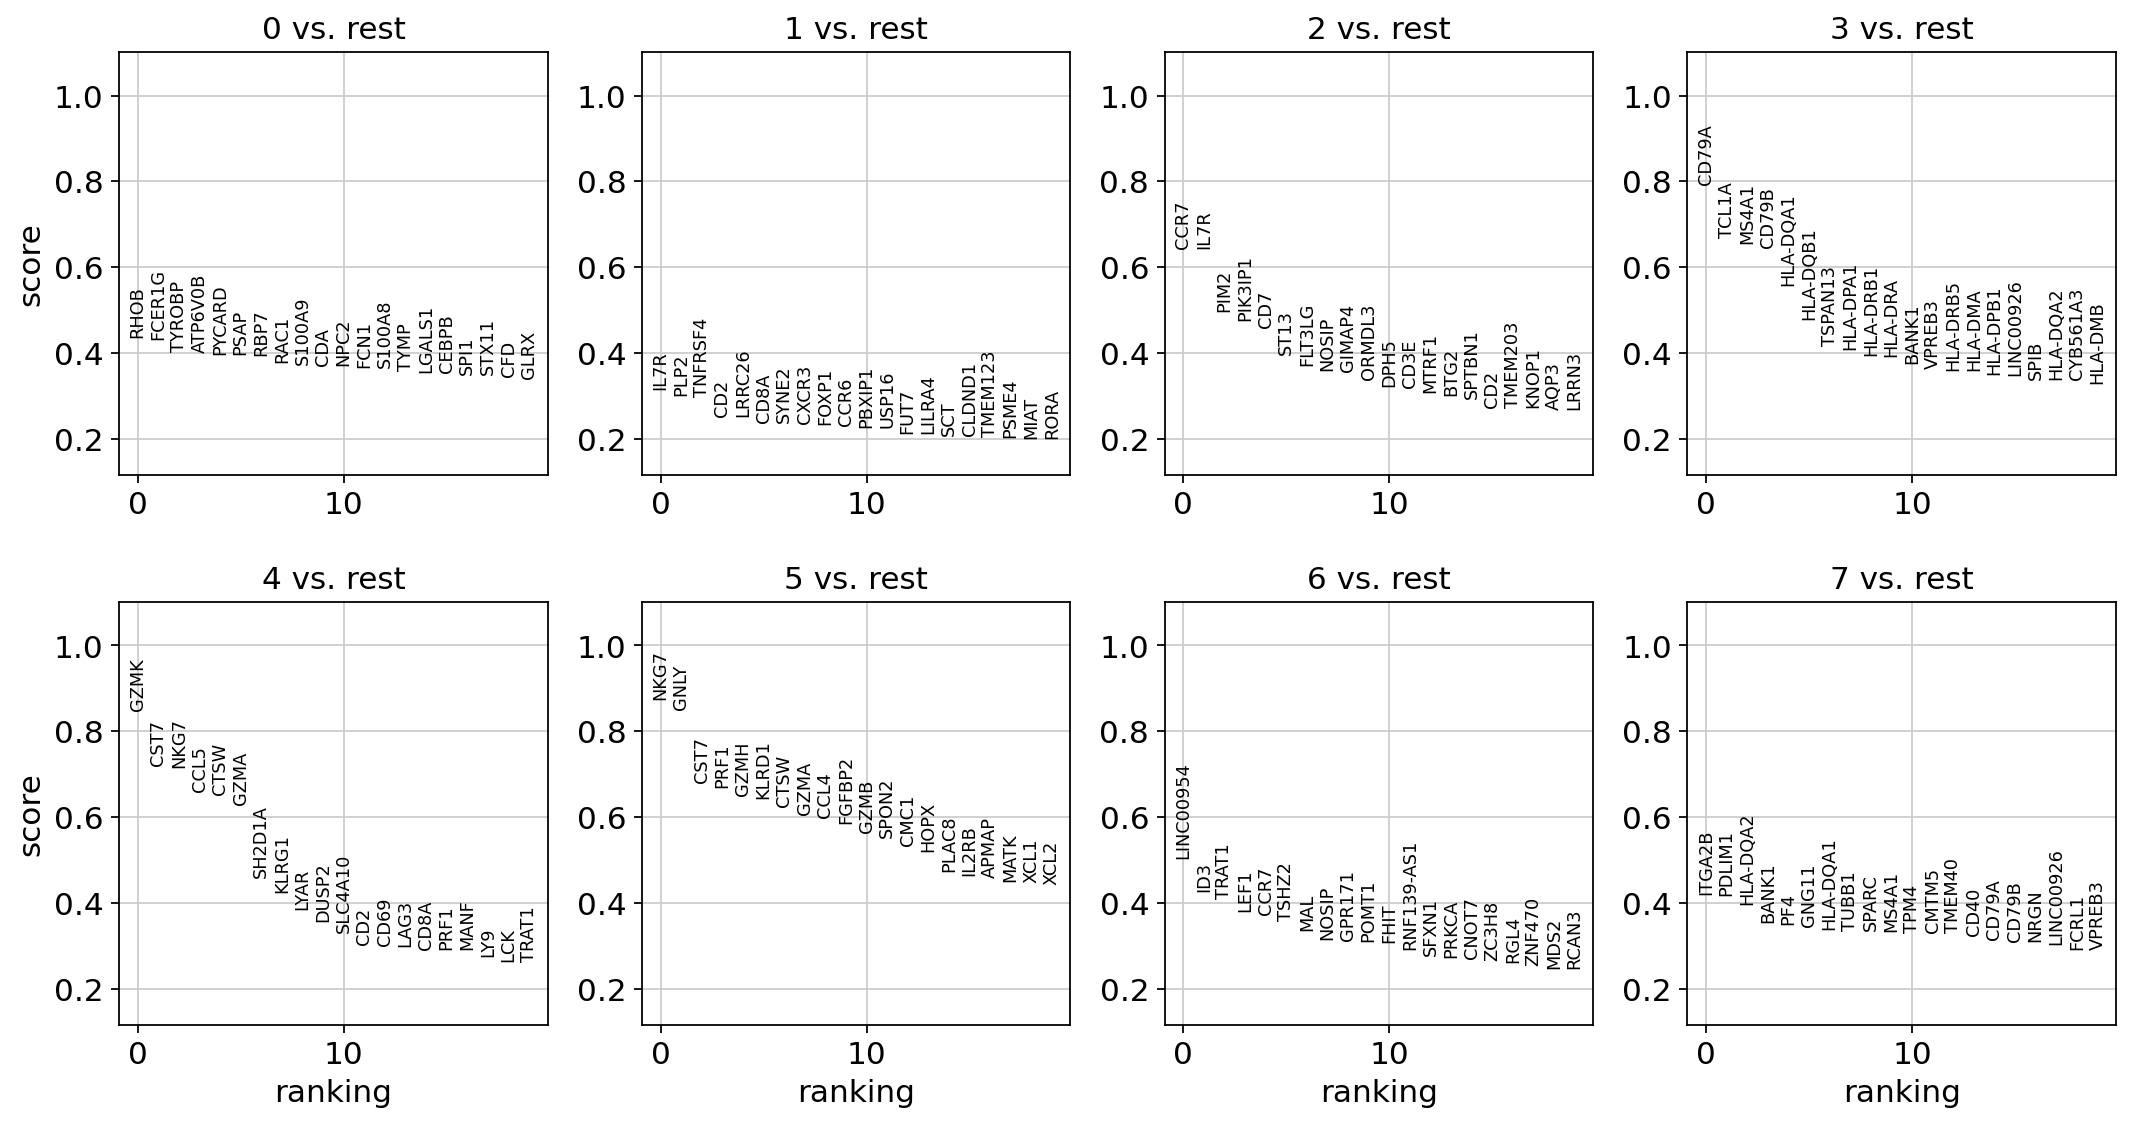

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)


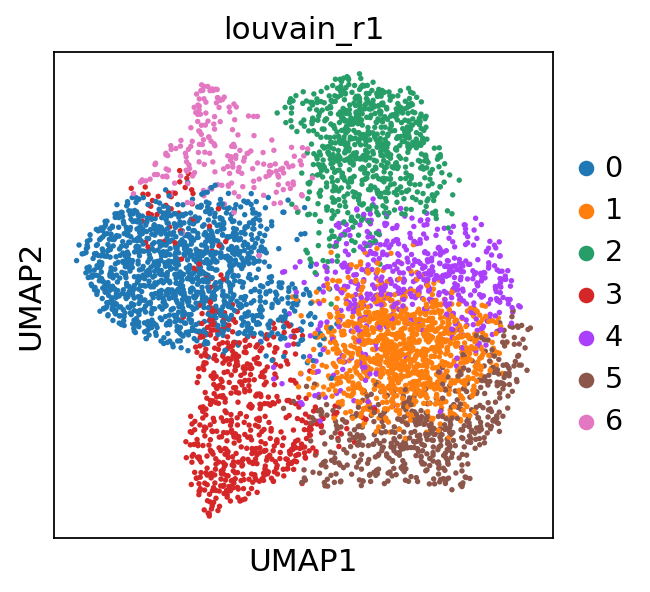

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:08)


/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


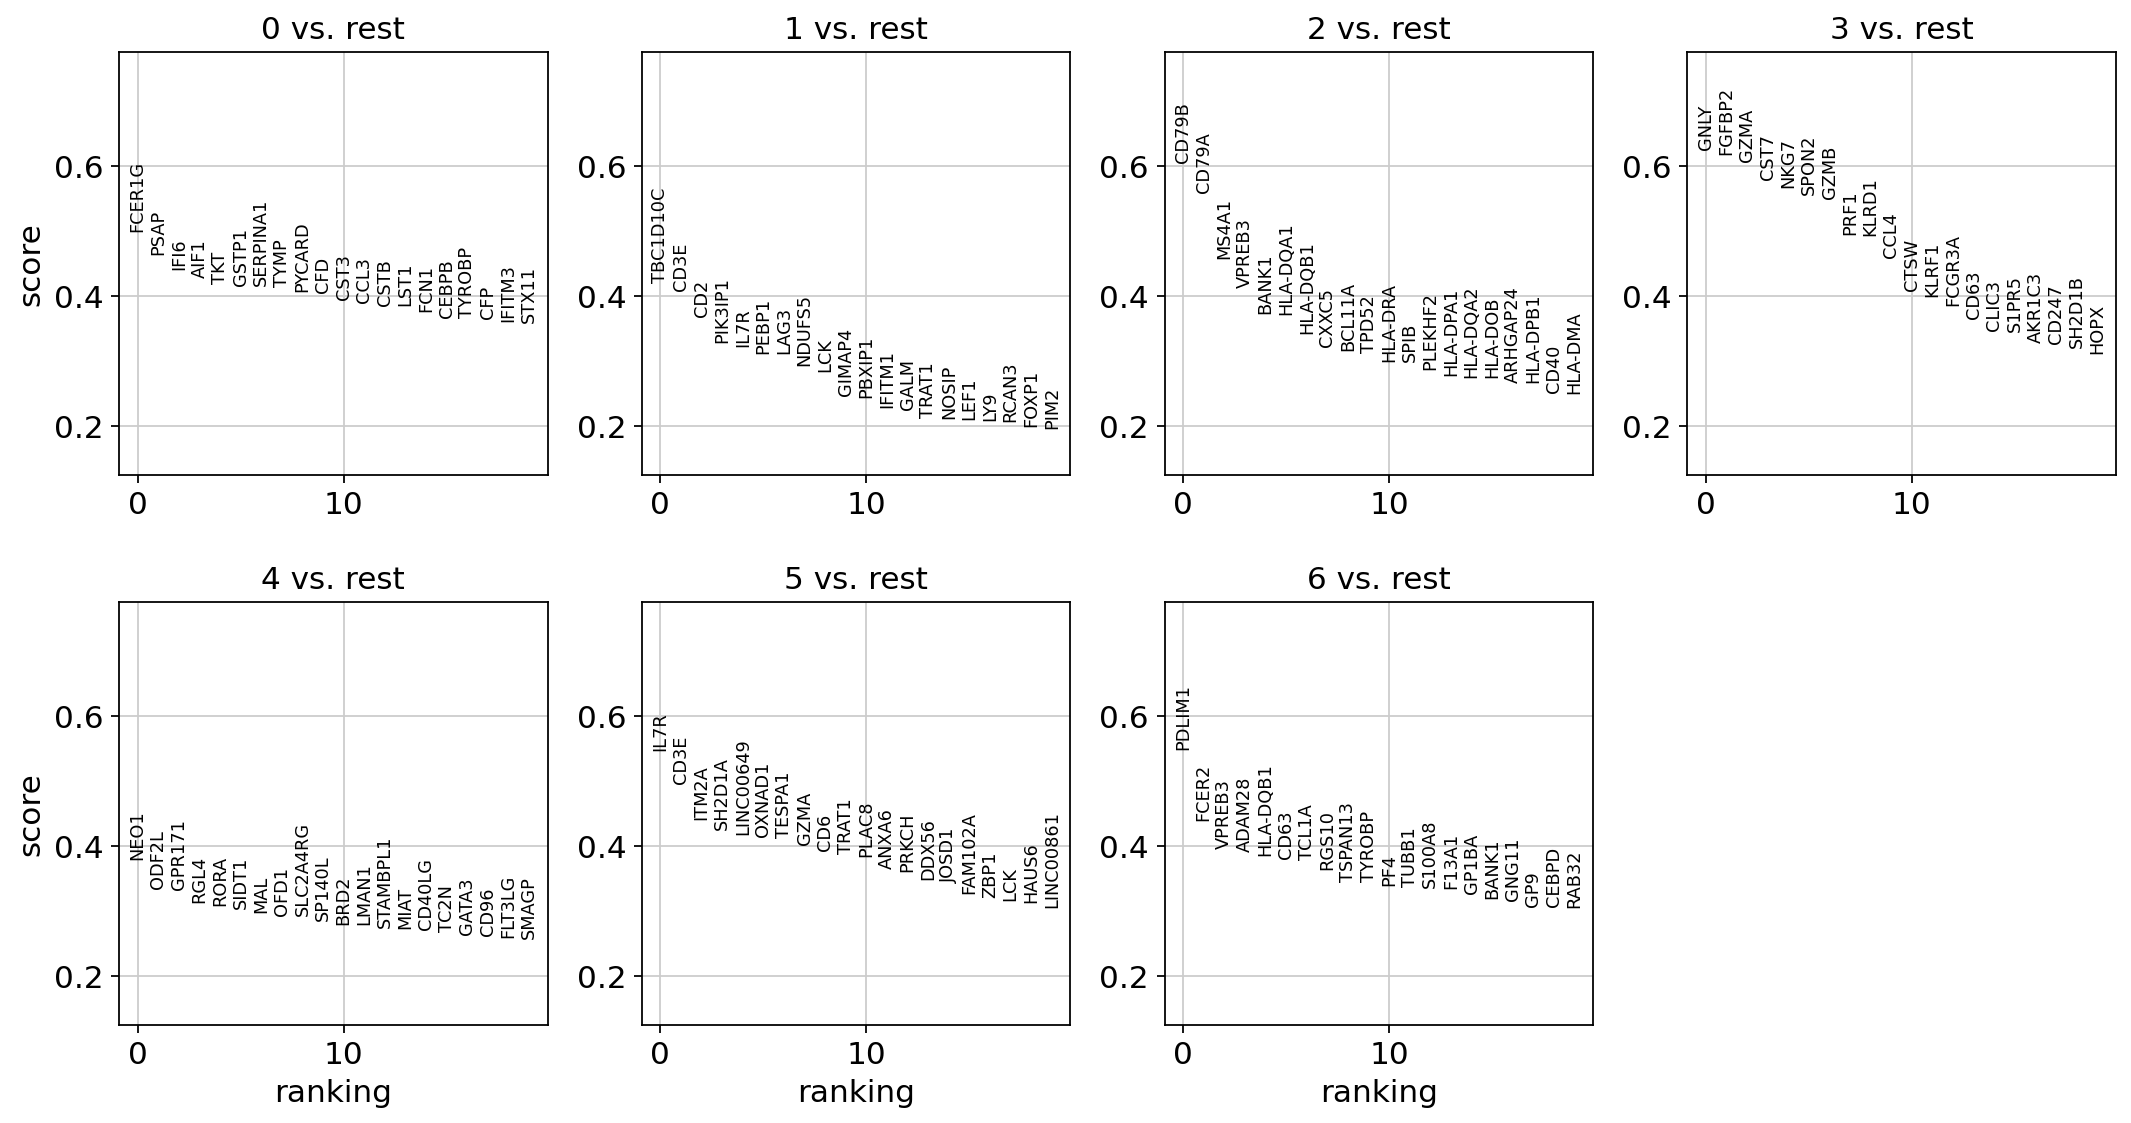

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)


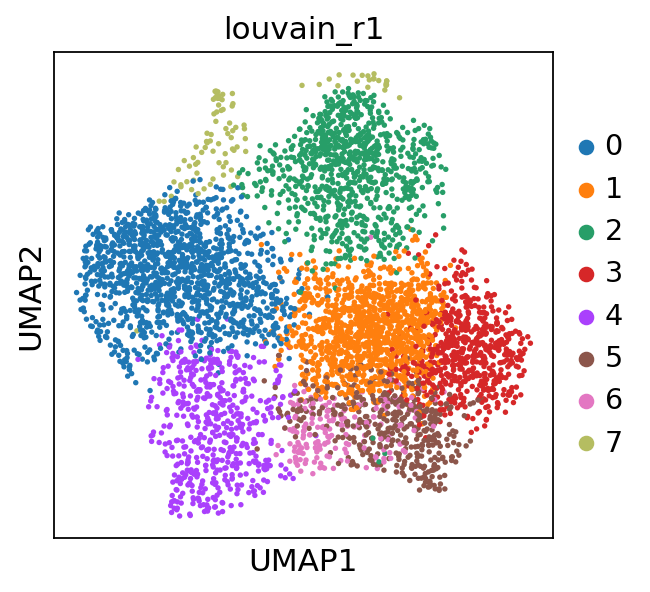

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:08)


/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


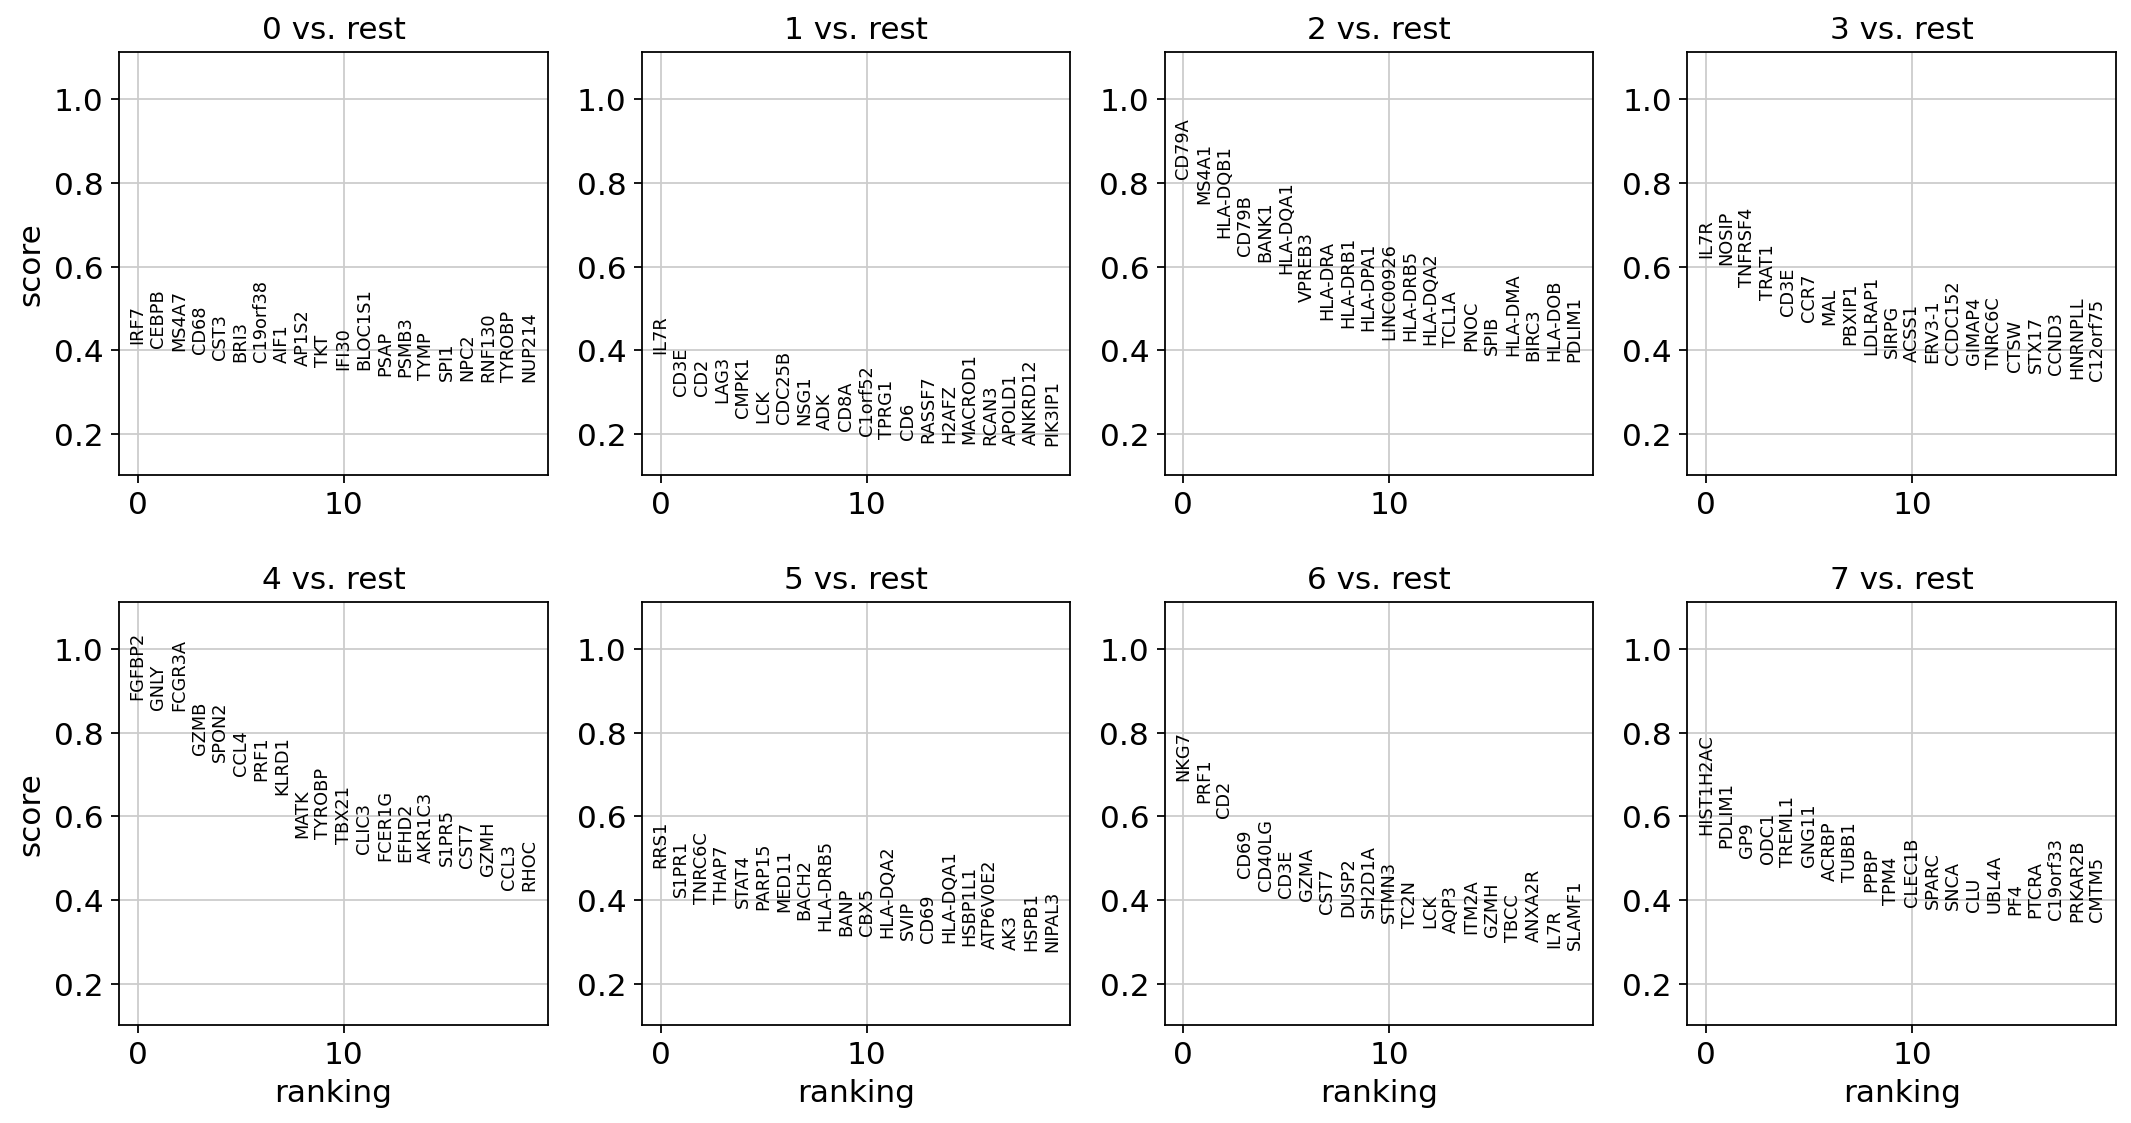

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)


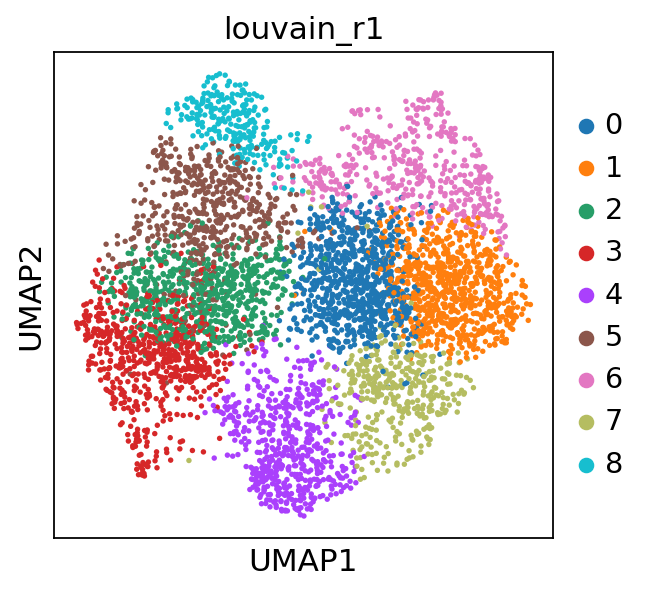

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:08)


/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


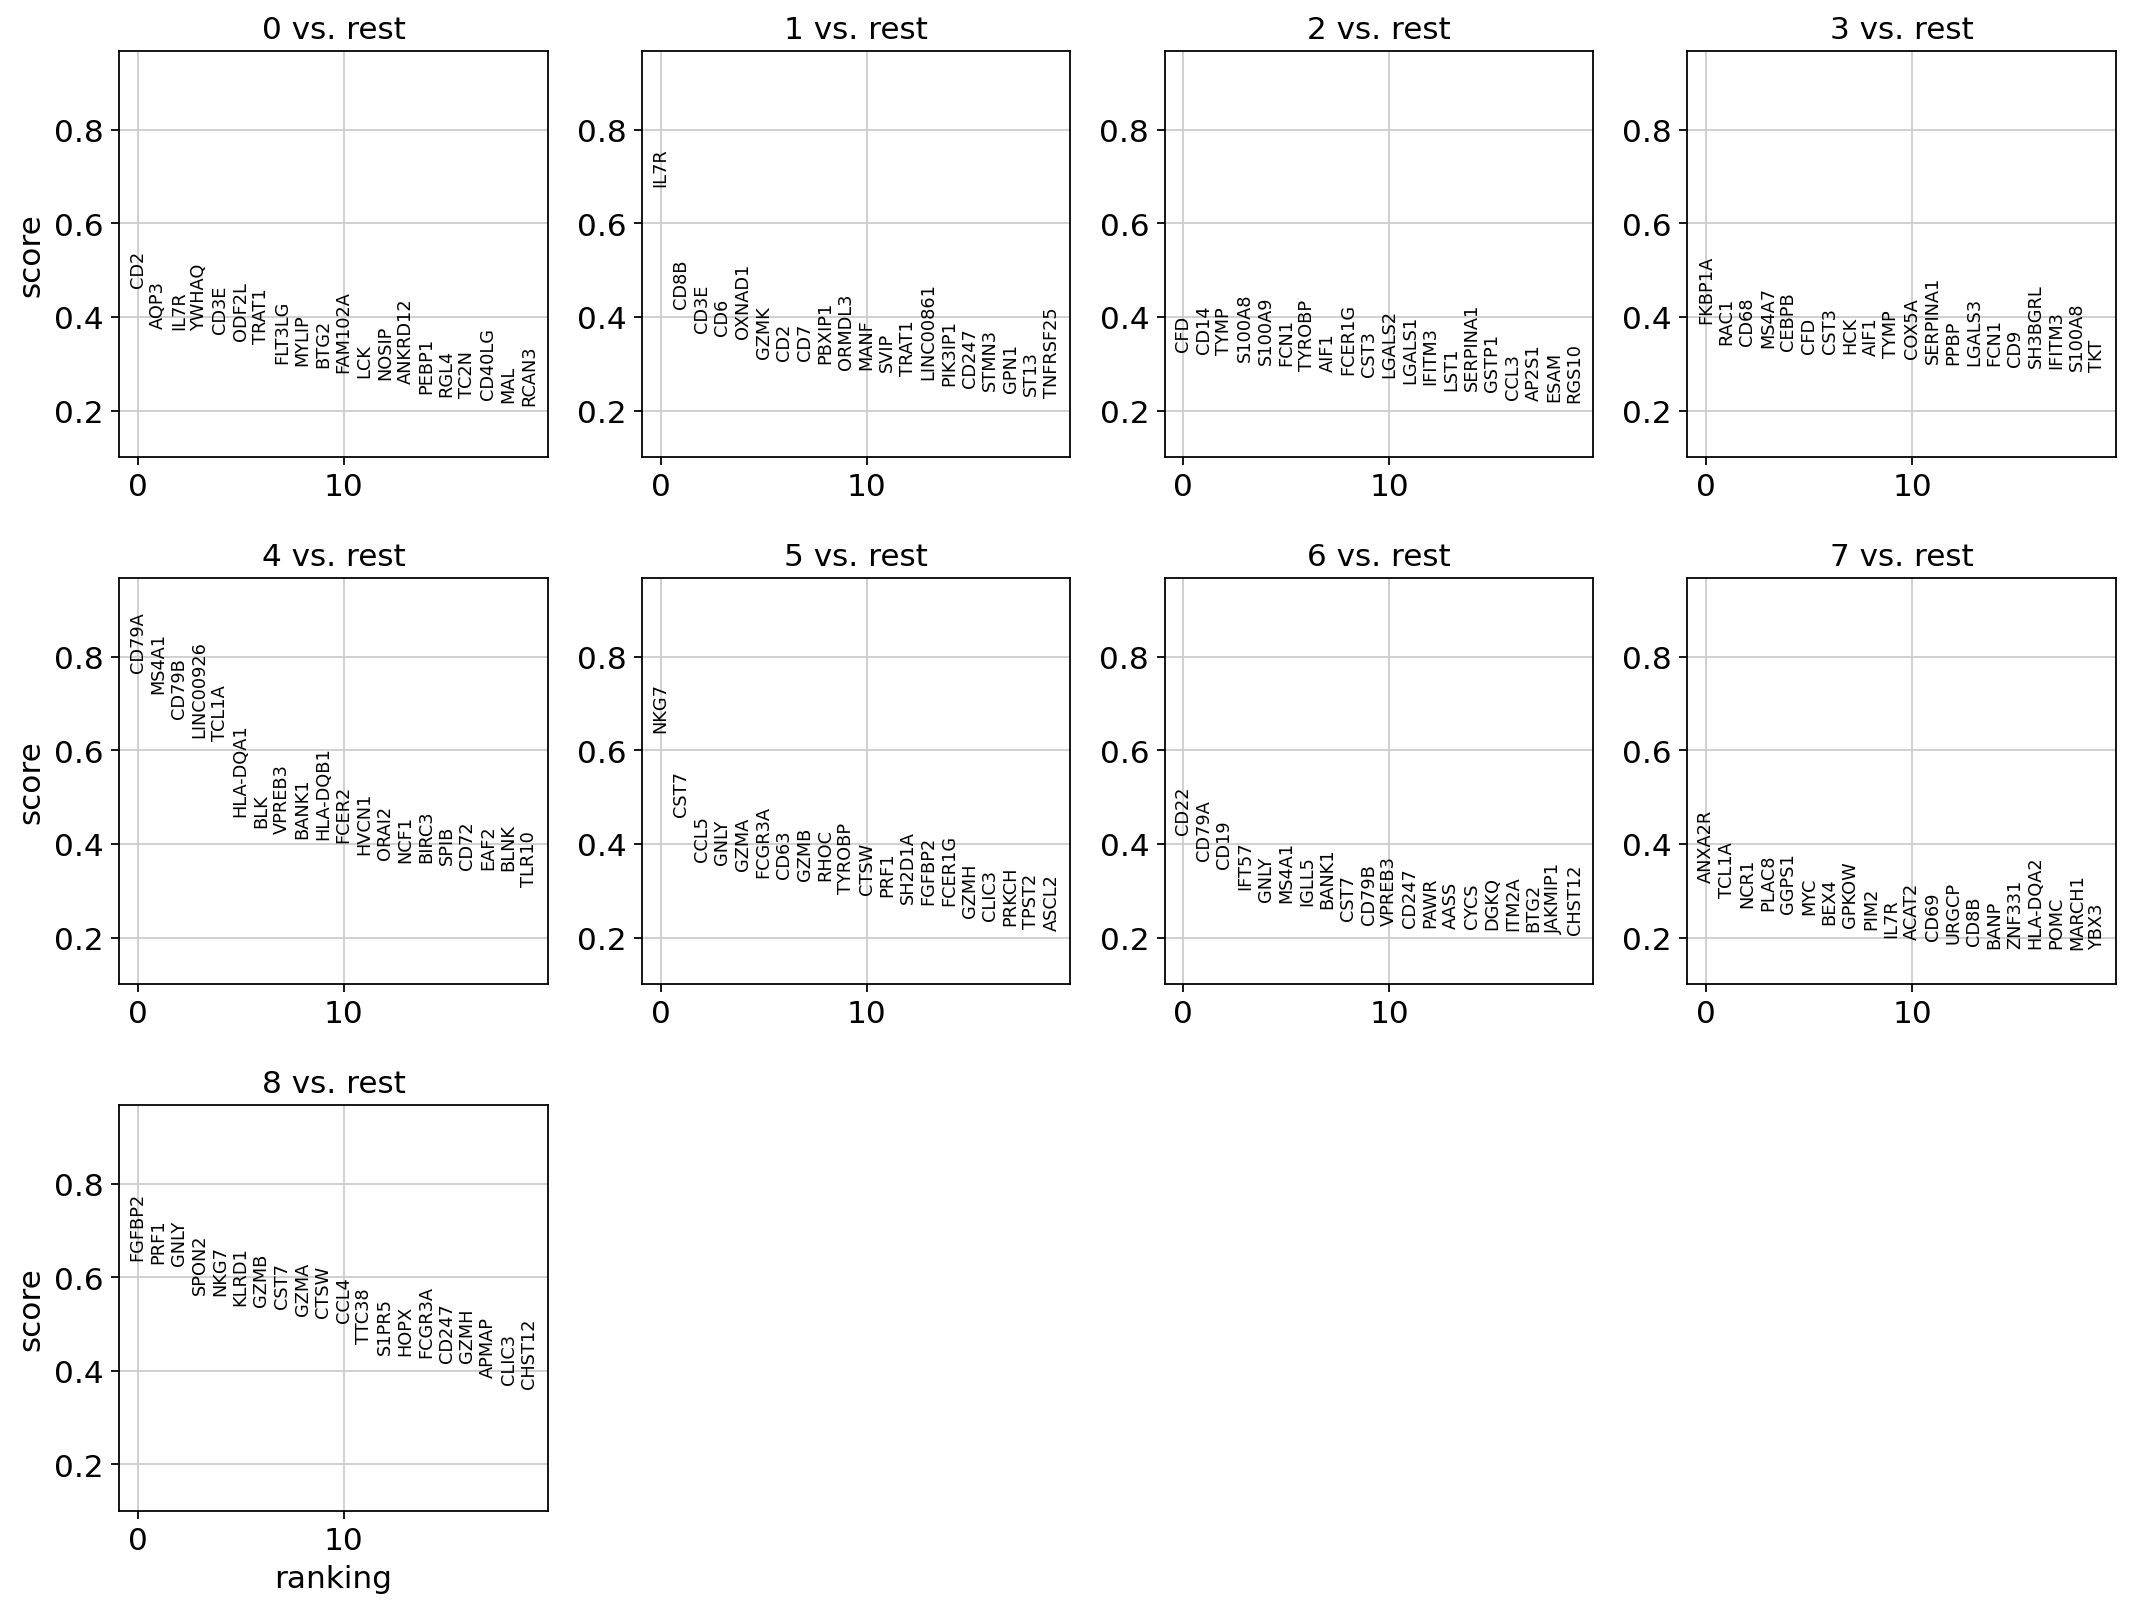

In [16]:
 for dataset in Generated_cells :
     test = dataset
     adata = sc.AnnData(test)
     adata.X
     sc.pp.neighbors(adata)
     sc.tl.umap(adata)
     sc.tl.louvain(adata, resolution=1, key_added='louvain_r1')
     sc.pl.umap(adata, color='louvain_r1')
     sc.tl.rank_genes_groups(adata, 'louvain_r1', method='logreg')
     sc.pl.rank_genes_groups(adata, n_genes=20)
     result = adata.uns['rank_genes_groups']
     groups = result['names'].dtype.names
     pd.DataFrame({group + '_' + key[:1]: result[key][group]
         for group in groups for key in ['names', 'scores']}).head(10)
       


In [ ]:
val = sc.AnnData(validation)
val = val.X
val = pd.DataFrame(val)

cell_names = []
for i in range(num_cells ):
    cell_names.append("cell-{}".format(i +1))
        
val = pd.DataFrame(data=val.values, columns=exp_mat.columns, index = cell_names)
val = sc.AnnData(val)


In [ ]:
sc.pp.neighbors(val)
sc.tl.umap(val)
sc.tl.louvain(val, resolution=1, key_added='louvain_r1')
sc.pl.umap(val, color='louvain_r1')
sc.tl.rank_genes_groups(val, 'louvain_r1', method='logreg')
sc.pl.rank_genes_groups(val, n_genes=20)
result = val.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
for group in groups for key in ['names', 'scores']}).head(10)
       

In [ ]:

for dataset in Generated_cells_val:
    gen = dataset
    
    corr = gen.corrwith(val, axis = 1) 
    
    corr = np.array(list(corr))
    
    
    plt.figure()        
    plt.hist(corr, density=True, range = (0,1))  # `density=False` would make counts
    plt.ylabel('Density')
    plt.xlabel('Correlation');   

            
            
        
    
    

In [ ]:

for dataset in Generated_cells:
    gen = dataset.T
    corr = gen.corr()
    corr = corr.to_numpy()
    corr= corr.flatten()
    

    plt.figure()        
    plt.hist(corr, density=True, range = (0,1))  # `density=False` would make counts
    plt.ylabel('Density')
    plt.xlabel('Correlation');    

In [ ]:
val = val.T
corr = val.corr()
corr
#corr= abs(corr)
plt.figure()        
plt.hist(corr, density=True, range = (0,1))  # `density=False` would make counts
plt.ylabel('Density')
plt.xlabel('Correlation');  

In [ ]:
for dataset in Generated_cells:
    gen = dataset.T
    corr = gen.corr()
    gen.reset_index(drop=True, inplace=True)
    #corr = corr.as_matrix()
    #corr= abs(corr)
    plt.figure()        
    plt.hist(corr, density=True, range = (0,1))  # `density=False` would make counts
    plt.ylabel('Density')
    plt.xlabel('Correlation');    

In [ ]:
#corr = corr.to_numpy()
corr= corr.flatten()
plt.hist(corr, density=True, range = (0,1))  # `density=False` would make counts
plt.ylabel('Density')
plt.xlabel('Correlation');    

In [ ]:


out_dim